In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_dodge_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_void_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_sheep_fear.wav
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set d

In [15]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
import librosa
import numpy as np
import pandas as pd


In [16]:
tf.random.set_seed(42)

# Paths to datasets
BerlinDB = "/kaggle/input/berlin-database-of-emotional-speech-emodb"
Tess_path = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"



In [17]:
# Load EmoDB dataset
berlin_directory_list = os.listdir(BerlinDB)

file_emotion = []
file_path = []

for dir in berlin_directory_list:
    directories = os.listdir(BerlinDB + "/" + dir)
    
    for file in directories:
        file_path.append(BerlinDB + "/wav/" +file)
        part = file.split(".")[0]
        ele = part[5]
        if ele=='W':
            file_emotion.append('angry')
        elif ele=='E':
            file_emotion.append('disgust')
        elif ele=='A':
            file_emotion.append('fear')
        elif ele=='F':
            file_emotion.append('happy')
        elif ele=='N':
            file_emotion.append('neutral')
        elif ele=='T':
            file_emotion.append('sad')
        else:
            file_emotion.append('boredom')

# DataFrame for EmoDB
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Berlin_df = pd.concat([emotion_df, path_df], axis=1)



In [18]:
# Load TESS dataset
Tess_dir_list = os.listdir(Tess_path)
emotions_tess = []
path_tess = []

for it in Tess_dir_list:
    directories = os.listdir(Tess_path + '/' + it)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            emotions_tess.append('surprise')
        else:
            emotions_tess.append(part)
        path_tess.append(Tess_path + it + '/' + file)
        
# DataFrame for TESS
emotion_tess_df = pd.DataFrame(emotions_tess, columns=['Emotions'])
path_tess_df = pd.DataFrame(path_tess, columns=['Path'])
Tess_df = pd.concat([emotion_tess_df, path_tess_df], axis=1)



In [19]:
# Combine datasets
combined_df = pd.concat([Berlin_df, Tess_df], ignore_index=True)



In [20]:
# Display the combined DataFrame
combined_df.head()


,Emotions,Path
0,happy,/kaggle/input/berlin-database-of-emotional-spe...
1,happy,/kaggle/input/berlin-database-of-emotional-spe...
2,angry,/kaggle/input/berlin-database-of-emotional-spe...
3,angry,/kaggle/input/berlin-database-of-emotional-spe...
4,angry,/kaggle/input/berlin-database-of-emotional-spe...


In [21]:
combined_df['Emotions'].value_counts()

Emotions
angry       527
neutral     479
happy       471
fear        469
sad         462
disgust     446
surprise    400
boredom      81
Name: count, dtype: int64

In [22]:
# Remove 'boredom' values
combined_df = combined_df[combined_df['Emotions'] != 'boredom']

In [23]:
# Function to sample 400 values per emotion
def balance_emotions(df, num_samples=400):
    balanced_df = pd.DataFrame(columns=df.columns)
    for emotion in df['Emotions'].unique():
        emotion_df = df[df['Emotions'] == emotion]
        if len(emotion_df) >= num_samples:
            sampled_df = emotion_df.sample(n=num_samples, random_state=42)
        else:
            sampled_df = emotion_df
        balanced_df = pd.concat([balanced_df, sampled_df])
    return balanced_df



In [24]:
# Balance the DataFrame
balanced_df = balance_emotions(combined_df)

# Shuffle the DataFrame to mix the samples
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [25]:
# Display the value counts to verify
print(balanced_df['Emotions'].value_counts())


Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


In [26]:
balanced_df.head()

,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,angry,/kaggle/input/toronto-emotional-speech-set-tes...
2,disgust,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,neutral,/kaggle/input/toronto-emotional-speech-set-tes...


In [27]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    
    # Extract MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs = np.mean(mfccs.T, axis=0)
    
    # Extract Mel Spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    mel = np.mean(mel.T, axis=0)
    
    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma = np.mean(chroma.T, axis=0)
    
    # Combine features
    features = np.hstack([mfccs, mel, chroma])
    
    return features

In [28]:
# Apply feature extraction to the DataFrame
features_list = []
for index, row in balanced_df.iterrows():
    features = extract_features(row['Path'])
    features_list.append(features)

# Convert to DataFrame
features_df = pd.DataFrame(features_list)
features_df['Emotions'] = balanced_df['Emotions'].values


In [29]:
features_df

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,Emotions
0,-292.774200,16.913895,-12.274233,3.943232,-9.279813,8.980408,-5.710565,-6.863700,5.091005,-11.846714,...,0.270156,0.200026,0.214217,0.305964,0.339256,0.289327,0.305826,0.361097,0.350920,fear
1,-326.853882,26.344694,-1.362442,3.262479,-27.585648,4.855551,-19.862680,-5.221193,-9.389168,-9.088059,...,0.203738,0.210395,0.282651,0.334207,0.345529,0.340814,0.482417,0.511764,0.456464,angry
2,-414.967316,91.465233,20.226763,0.157852,10.674459,-12.502218,-4.584141,-13.961825,-8.345692,-6.892576,...,0.385822,0.368098,0.431280,0.472561,0.406085,0.372354,0.377696,0.349413,0.310586,disgust
3,-387.680969,59.989601,-3.548398,-17.718145,0.824570,-5.477331,-7.917394,-10.900555,-12.816069,-13.083144,...,0.745098,0.378406,0.135343,0.064158,0.061341,0.074070,0.120256,0.202295,0.181816,fear
4,-512.304321,61.884678,16.734863,20.339970,4.098924,0.836250,-3.808757,-8.678870,-12.543158,-7.892901,...,0.116242,0.151521,0.390140,0.711220,0.413042,0.203634,0.177887,0.152671,0.216119,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,-204.650360,93.244331,13.604545,44.061981,-9.224625,15.467529,-18.129740,-9.125637,-9.638115,-8.815038,...,0.414559,0.458121,0.460102,0.386404,0.203291,0.147688,0.239629,0.216563,0.228071,neutral
2796,-319.030334,44.884052,-6.935380,13.013007,-17.929659,5.600037,-6.901025,-12.407508,5.776263,-17.007925,...,0.225679,0.253024,0.369600,0.299044,0.245729,0.245572,0.304349,0.243817,0.279501,fear
2797,-428.479553,69.097374,0.576857,-18.085945,8.340466,-11.073050,-14.369164,-7.533466,-16.870230,-13.335572,...,0.294546,0.151123,0.167921,0.165302,0.121313,0.107883,0.115257,0.152254,0.123240,fear
2798,-398.741699,54.802532,31.882372,19.557659,4.174762,5.177224,-16.673414,-0.460627,-6.261295,-5.243132,...,0.142765,0.152727,0.237282,0.303732,0.376786,0.457017,0.459150,0.333055,0.254155,sad


In [30]:
# Encode labels
label_encoder = LabelEncoder()
features_df['Emotions'] = label_encoder.fit_transform(features_df['Emotions'])

# Split data
X = features_df.drop(['Emotions'], axis=1).values
y = to_categorical(features_df['Emotions'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Reshape data for CNN + LSTM model
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Build the CNN + LSTM model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model with the checkpoint callback
history = model.fit(X_train, y_train, epochs=110, batch_size=32, validation_split=0.2, verbose=1, callbacks=[checkpoint_callback])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Load the best weights
model.load_weights('best_model.keras')

# Save the final model with the best weights
model.save('speech_emotion_recognition_model2.keras')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/110
54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1725 - loss: 1.9133
Epoch 1: val_accuracy improved from -inf to 0.21205, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.1743 - loss: 1.9111 - val_accuracy: 0.2121 - val_loss: 1.7526
Epoch 2/110
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2950 - loss: 1.7260
Epoch 2: val_accuracy improved from 0.21205 to 0.29464, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2951 - loss: 1.7252 - val_accuracy: 0.2946 - val_loss: 1.5660
Epoch 3/110
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3156 - loss: 1.5977
Epoch 3: val_accuracy improved from 0.29464 to 0.40848, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3158 - loss: 1.5976 - val_accuracy: 0.4085 - val_loss: 1.4292
Epoch 4/110
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3929 - loss: 1.4497
Epoch 4: val_accuracy improved from 0.40848 

In [32]:
import matplotlib.pyplot as plt

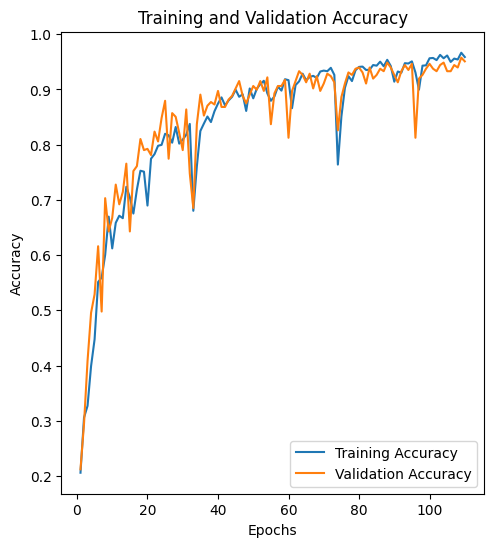

In [33]:
# Extract accuracy and loss values from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

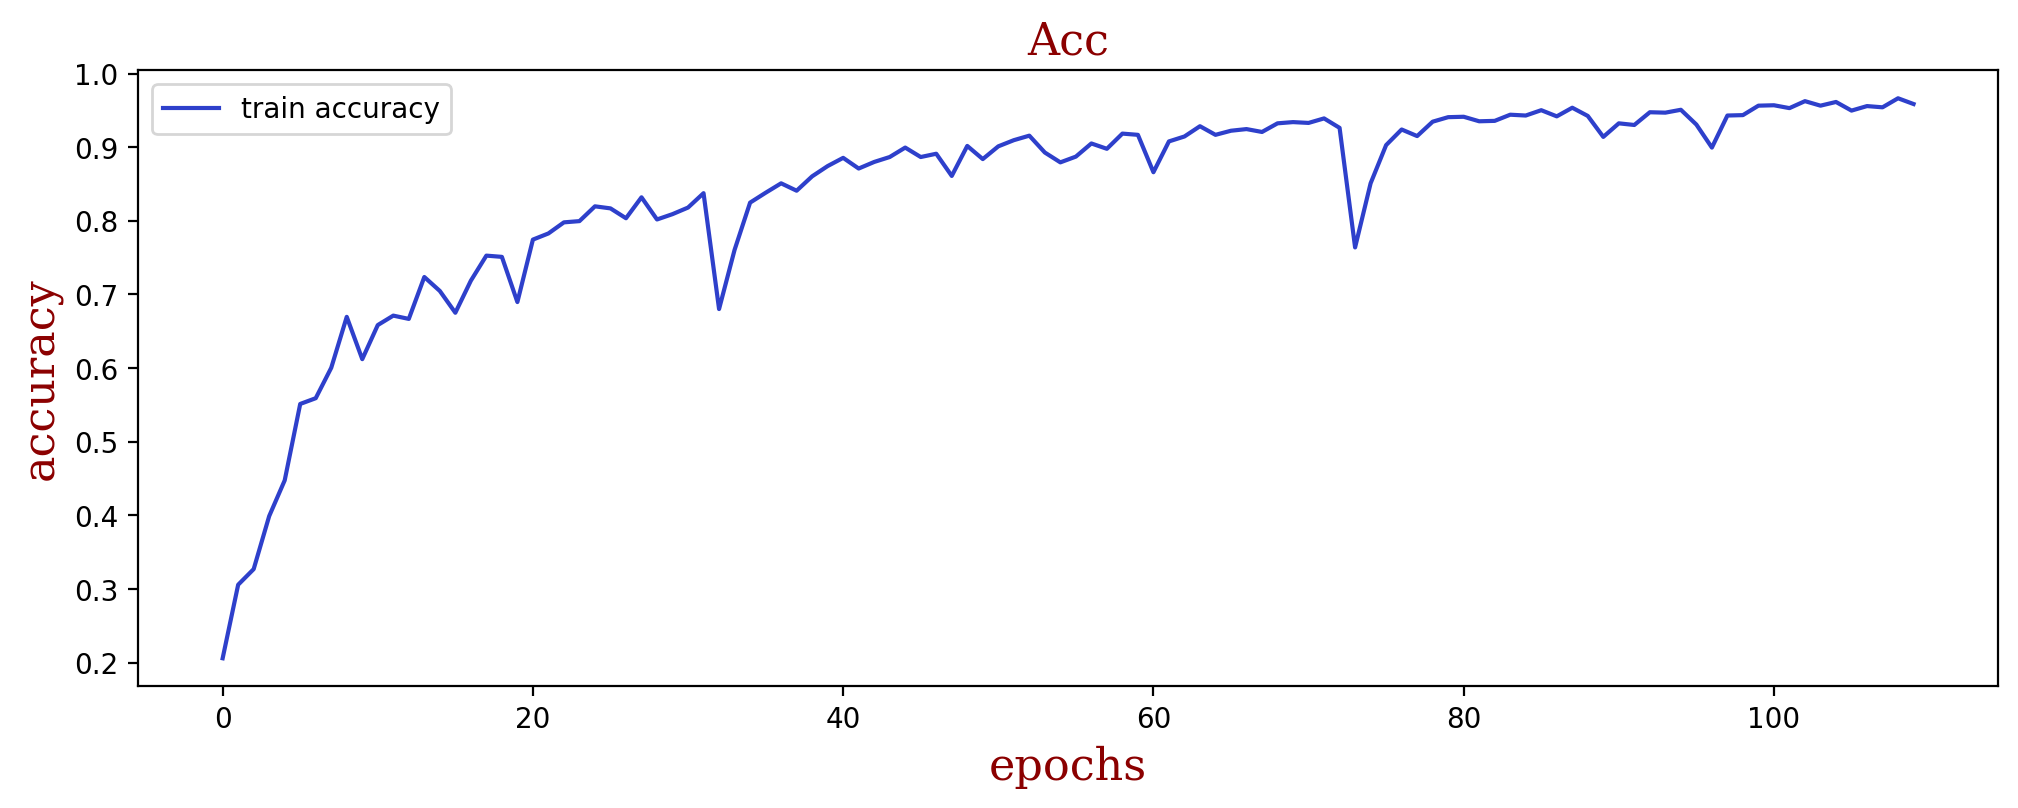

In [35]:
epochs = list(range(110))
acc = history.history['accuracy']
font2 = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16}

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, acc, label='train accuracy', color='#2E40CB')
plt.xlabel('epochs', fontdict= font2)
plt.ylabel('accuracy', fontdict= font2)
plt.title('Acc', fontdict= font2)
plt.legend()
plt.show()

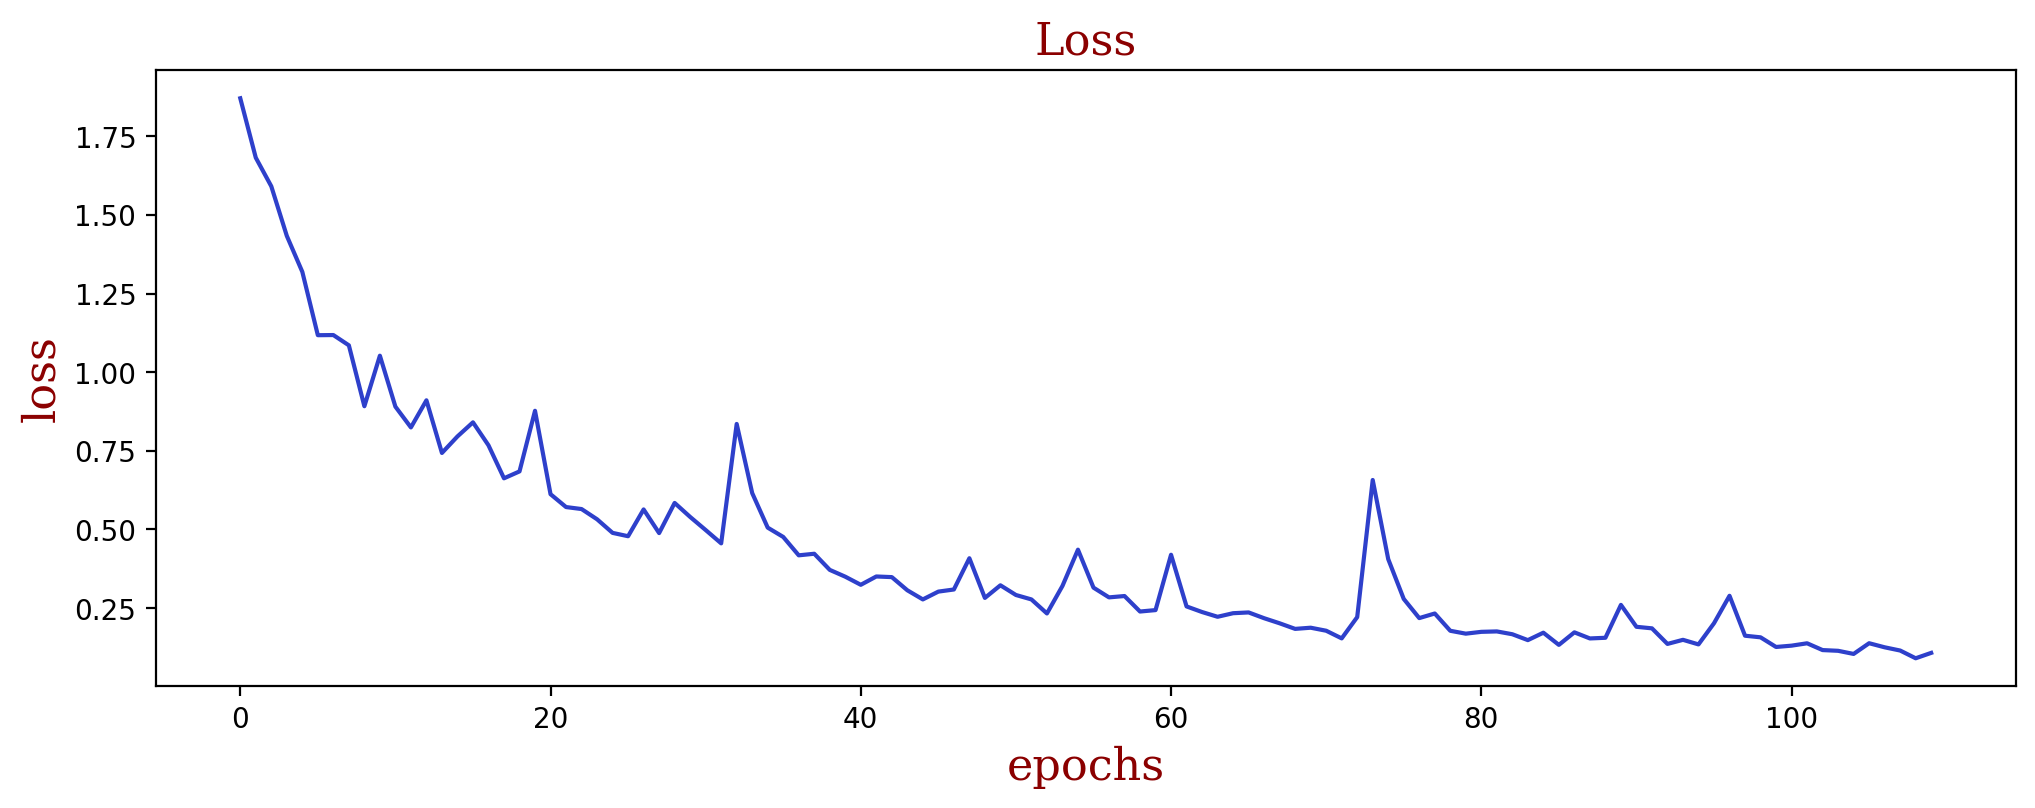

In [36]:
loss = history.history['loss']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, loss, label='train loss', color='#2E40CB')
plt.xlabel('epochs', fontdict= font2)
plt.ylabel('loss', fontdict= font2)
plt.title('Loss', fontdict= font2)
plt.show()

In [37]:
# Predict on the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([3, 0, 0, 2, 6, 0, 2, 3, 5, 1, 2, 3, 5, 1, 3, 0, 5, 0, 1, 4, 3, 3,
       2, 5, 6, 3, 0, 5, 2, 6, 3, 0, 4, 6, 4, 5, 5, 0, 3, 4, 0, 2, 2, 1,
       6, 0, 6, 6, 3, 5, 6, 6, 3, 2, 4, 3, 1, 0, 0, 3, 1, 4, 5, 1, 1, 3,
       3, 0, 2, 4, 3, 6, 1, 6, 4, 4, 4, 1, 0, 5, 2, 4, 0, 2, 2, 4, 0, 2,
       1, 4, 5, 1, 5, 0, 4, 3, 4, 6, 3, 3, 4, 2, 6, 1, 1, 2, 2, 4, 2, 0,
       4, 0, 0, 2, 0, 3, 5, 0, 5, 1, 5, 0, 0, 4, 0, 2, 2, 5, 5, 2, 1, 4,
       6, 1, 6, 6, 1, 1, 1, 2, 0, 1, 0, 2, 0, 3, 5, 6, 1, 0, 2, 0, 5, 0,
       2, 4, 0, 3, 3, 4, 4, 4, 1, 4, 4, 4, 5, 5, 6, 0, 4, 5, 3, 2, 6, 0,
       4, 1, 4, 1, 2, 3, 5, 0, 5, 3, 6, 2, 6, 3, 4, 1, 6, 4, 5, 2, 5, 2,
       1, 6, 5, 3, 6, 5, 6, 0, 6, 5, 3, 0, 2, 6, 0, 0, 0, 4, 5, 1, 4, 5,
       6, 1, 2, 2, 6, 5, 0, 2, 3, 5, 2, 3, 1, 2, 1, 3, 6, 4, 6, 4, 6, 1,
       4, 2, 2, 3, 6, 3, 6, 0, 0, 4, 1, 6, 6, 2, 6, 2, 3, 3, 5, 1, 3, 0,
       4, 5, 6, 1, 1, 2, 4, 2, 0, 2, 4, 0, 5, 4, 3, 2, 4, 5, 2, 1, 5, 5,
       3, 2, 4, 6, 5, 0, 0, 5, 3, 1, 5, 3, 1, 4, 2,

In [38]:
# Your true labels for the test set are already 'y_test'
y_true = y_test
# Convert one-hot encoded y_true to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_true_labels

array([3, 0, 0, 2, 6, 0, 4, 3, 5, 2, 2, 3, 5, 1, 3, 0, 5, 0, 1, 4, 3, 3,
       2, 5, 6, 3, 0, 5, 2, 6, 3, 0, 4, 6, 4, 5, 5, 3, 3, 4, 0, 2, 2, 1,
       6, 0, 6, 6, 3, 5, 6, 6, 3, 2, 4, 3, 1, 0, 0, 3, 1, 4, 5, 2, 1, 3,
       3, 0, 2, 4, 3, 6, 1, 6, 4, 4, 4, 1, 0, 5, 2, 4, 0, 1, 2, 4, 0, 2,
       1, 4, 5, 1, 5, 0, 4, 3, 4, 6, 3, 3, 4, 2, 6, 1, 1, 2, 2, 4, 3, 0,
       4, 4, 0, 2, 0, 3, 5, 0, 5, 1, 5, 0, 0, 4, 0, 2, 2, 5, 5, 2, 1, 4,
       6, 1, 6, 6, 6, 1, 1, 2, 0, 1, 0, 0, 0, 3, 5, 6, 1, 0, 2, 0, 5, 0,
       2, 4, 3, 3, 3, 4, 4, 4, 1, 4, 4, 4, 5, 5, 6, 0, 1, 5, 3, 2, 6, 0,
       4, 1, 4, 1, 2, 3, 5, 0, 5, 3, 6, 2, 6, 3, 3, 1, 6, 4, 5, 2, 5, 2,
       1, 6, 5, 3, 6, 5, 6, 0, 6, 5, 3, 0, 2, 6, 0, 0, 0, 4, 5, 1, 4, 5,
       6, 1, 2, 5, 6, 5, 0, 5, 3, 5, 2, 2, 1, 2, 3, 3, 6, 4, 6, 4, 6, 1,
       4, 2, 2, 3, 6, 3, 6, 0, 0, 4, 1, 6, 6, 2, 6, 5, 3, 3, 5, 1, 3, 0,
       4, 5, 6, 1, 3, 2, 4, 2, 0, 2, 4, 0, 5, 4, 3, 2, 4, 5, 2, 1, 5, 5,
       3, 3, 4, 6, 5, 0, 0, 5, 3, 1, 5, 3, 1, 4, 3,

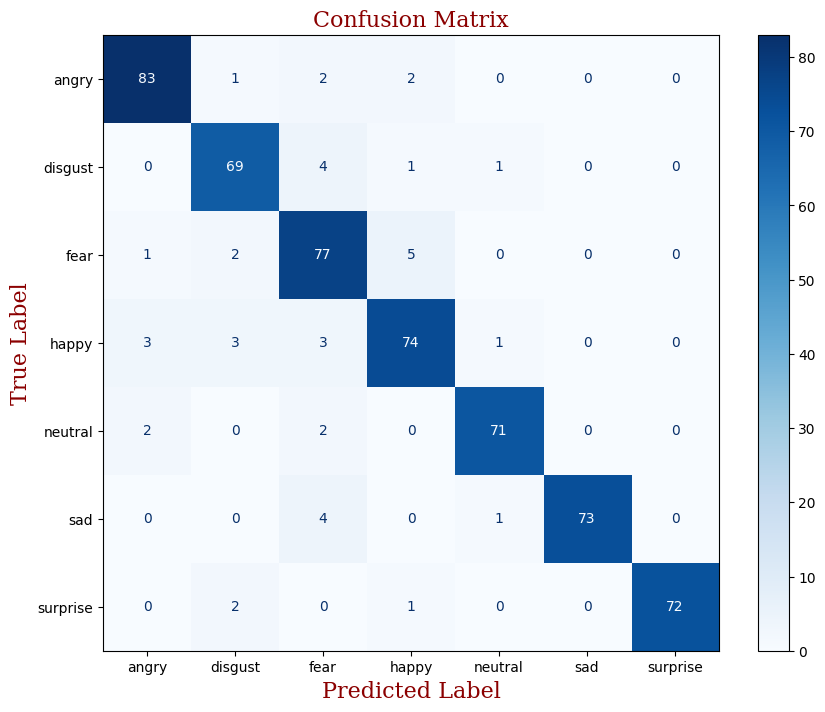

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])  
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.xlabel('Predicted Label', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.ylabel('True Label', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.show()


In [40]:
from sklearn.metrics import f1_score

# Assuming y_true_labels and y_pred are already defined
f1 = f1_score(y_true_labels, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
print(f'F1 Score: {f1:.4f}')


F1 Score: 0.9275


In [41]:
from sklearn.metrics import classification_report

report = classification_report(y_true_labels, y_pred, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
print(report)


              precision    recall  f1-score   support

       angry       0.93      0.94      0.94        88
     disgust       0.90      0.92      0.91        75
        fear       0.84      0.91      0.87        85
       happy       0.89      0.88      0.89        84
     neutral       0.96      0.95      0.95        75
         sad       1.00      0.94      0.97        78
    surprise       1.00      0.96      0.98        75

    accuracy                           0.93       560
   macro avg       0.93      0.93      0.93       560
weighted avg       0.93      0.93      0.93       560



Accuracy: 0.9268
Precision: 0.9290
Recall: 0.9268
F1 Score: 0.9275
ROC-AUC Score: 0.9948
              precision    recall  f1-score   support

       angry       0.93      0.94      0.94        88
     disgust       0.90      0.92      0.91        75
        fear       0.84      0.91      0.87        85
       happy       0.89      0.88      0.89        84
     neutral       0.96      0.95      0.95        75
         sad       1.00      0.94      0.97        78
    surprise       1.00      0.96      0.98        75

    accuracy                           0.93       560
   macro avg       0.93      0.93      0.93       560
weighted avg       0.93      0.93      0.93       560



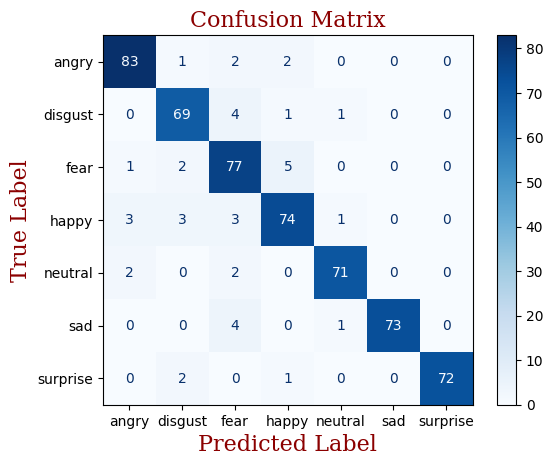

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Calculate metrics
accuracy = accuracy_score(y_true_labels, y_pred)
precision = precision_score(y_true_labels, y_pred, average='weighted')
recall = recall_score(y_true_labels, y_pred, average='weighted')
f1 = f1_score(y_true_labels, y_pred, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# ROC-AUC Score 
roc_auc = roc_auc_score(y_true_labels, y_pred_prob, multi_class='ovr')
print(f'ROC-AUC Score: {roc_auc:.4f}')

# Classification Report
report = classification_report(y_true_labels, y_pred, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.xlabel('Predicted Label', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.ylabel('True Label', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.show()
